In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.1 MB/s eta 0:00:00


In [ ]:
import os
import torch
from PIL import Image, ImageDraw
import numpy as np
from torch.utils.data import DataLoader
from monai.transforms import Compose, EnsureChannelFirst, ScaleIntensity, Resize, EnsureType
import json
import torch.nn as nn
import torch.optim as optim
from monai.networks.nets import UNet
import matplotlib.pyplot as plt

### Eğitim Klasörlerinin Yüklenmesi ve Normalizasyon

In [ ]:
# Görüntüleri ve maskeleri yüklemek için fonksiyon
def load_images_and_masks(image_dir, mask_dir=None):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg") or f.endswith(".png")])
    images = []
    masks = []

    for img_file in image_files:
        # Görüntüyü yükleme (grayscale olacak şekilde)
        img_path = os.path.join(image_dir, img_file)
        image = Image.open(img_path).convert("L")  # "L" parametresi grayscale (tek kanal) olarak dönüştürür
        image = np.array(image)

        images.append(image)

        # Maske yükleme (eğer maske varsa)
        if mask_dir:
            mask_path = os.path.join(mask_dir, os.path.splitext(img_file)[0] + '.png')
            mask = Image.open(mask_path)
            mask = np.array(mask)
            mask=mask>150
            masks.append(mask)

    return images, masks if mask_dir else images

# Yeni yollar
image_dir = "/content/name"
mask_dir = "/content/name"

# Görüntüleri ve maskeleri yükleme
train_images, train_masks = load_images_and_masks(image_dir=image_dir, mask_dir=mask_dir)

# Görüntü ve maskeleri dönüştürme
transform = Compose([
    ScaleIntensity(),  # Görüntüleri normalize ediyoruz
    EnsureType()  # Tensor tipine dönüştürüyoruz
])

train_images = [transform(torch.tensor(img).unsqueeze(0)) for img in train_images]  # Kanal boyutu için unsqueeze(0) ekliyoruz
train_masks = [transform(torch.tensor(mask).unsqueeze(0)) for mask in train_masks]

# DataLoader için verileri hazırlama
train_data = list(zip(train_images, train_masks))
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)

In [ ]:
train_masks[0].max()

metatensor(1.)

### Model Tanımlaması ve Optimizasyon

In [ ]:
# Cihaz kontrolü (GPU varsa kullanılır)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# UNet Modeli
model = UNet(
    spatial_dims=2,  # 2D görüntüler üzerinde çalışıyoruz
    in_channels=1,  # Gri görüntü (tek kanal)
    out_channels=2,  # 3 sınıf sağlıklı bölge, MS lezyonları ve arka plan
    channels=(16, 32, 64, 128, 256),  # UNet'teki katmanların genişlikleri
    strides=(2, 2, 2, 2),  # Katmanlar arasındaki sıçramalar
    num_res_units=2,  # Residual Unit sayısı
).to(device)

# Kayıp fonksiyonu ve optimizer
loss_function = nn.CrossEntropyLoss()  # Çok sınıflı sınıflandırma için uygun
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer, öğrenme oranı 0.0001

### Model Eğitimi

In [ ]:
# Kayıp ve doğruluk değerlerini kaydetmek için boş listeler
losses = []
accuracies = []

# Eğitim döngüsü
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    total_pixels = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        masks = masks.squeeze(1)
        masks = masks.long()

        outputs = model(images)
        loss = loss_function(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        predicted_masks = outputs.argmax(dim=1)
        correct_predictions += (predicted_masks == masks).sum().item()
        total_pixels += masks.numel()

    # Epoch başına ortalama kayıp ve doğruluğu hesaplayın
    avg_loss = epoch_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_pixels

    # Listelere ekleyin
    losses.append(avg_loss)
    accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

Epoch 1/50, Loss: 0.8644, Accuracy: 0.4463
Epoch 2/50, Loss: 0.7705, Accuracy: 0.4896
Epoch 3/50, Loss: 0.7191, Accuracy: 0.5276
Epoch 4/50, Loss: 0.6878, Accuracy: 0.5544
Epoch 5/50, Loss: 0.6636, Accuracy: 0.5811
Epoch 6/50, Loss: 0.6434, Accuracy: 0.6063
Epoch 7/50, Loss: 0.6272, Accuracy: 0.6160
Epoch 8/50, Loss: 0.6129, Accuracy: 0.6218
Epoch 9/50, Loss: 0.5987, Accuracy: 0.6277
Epoch 10/50, Loss: 0.5848, Accuracy: 0.6339
Epoch 11/50, Loss: 0.5723, Accuracy: 0.6389
Epoch 12/50, Loss: 0.5597, Accuracy: 0.6442
Epoch 13/50, Loss: 0.5477, Accuracy: 0.6480
Epoch 14/50, Loss: 0.5361, Accuracy: 0.6521
Epoch 15/50, Loss: 0.5252, Accuracy: 0.6576
Epoch 16/50, Loss: 0.5140, Accuracy: 0.6683
Epoch 17/50, Loss: 0.5032, Accuracy: 0.6910
Epoch 18/50, Loss: 0.4926, Accuracy: 0.7211
Epoch 19/50, Loss: 0.4826, Accuracy: 0.7467
Epoch 20/50, Loss: 0.4725, Accuracy: 0.7848
Epoch 21/50, Loss: 0.4626, Accuracy: 0.8331
Epoch 22/50, Loss: 0.4530, Accuracy: 0.8748
Epoch 23/50, Loss: 0.4437, Accuracy: 0.89

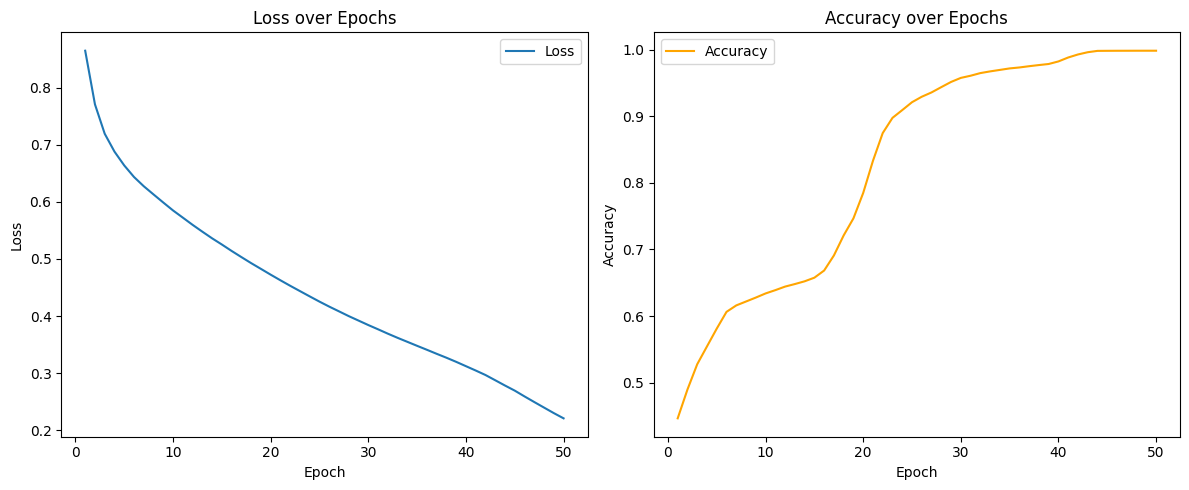

In [ ]:
import matplotlib.pyplot as plt

# Epoch başına kayıp grafiği
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Epoch başına doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), accuracies, label="Accuracy", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

### **Test Klasörünü Yükleme**

In [ ]:
# Test dizinindeki görüntüleri manuel olarak yükleyelim
def load_test_images(image_dir):
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]
    images = []

    # Her görüntüyü yükleyip listeye ekleyelim
    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        image = Image.open(img_path).convert('L')  # Siyah-beyaz (gri ölçekli) görüntü olarak yükleyelim
        images.append(np.array(image))  # Görüntüyü numpy array'e çevirerek ekliyoruz

    return images

# Test görüntülerini yükleyelim
test_images = load_test_images('/content/name')

# Toplam test görüntü sayısını kontrol edelim
print(f"Toplam Test Görüntü Sayısı: {len(test_images)}")  # Yüklü görüntü sayısını kontrol edelim

# Transform işlemi tanımlama
transform = Compose([
    ScaleIntensity(),  # Görüntü değerlerini normalize eder
    EnsureType()       # Tensor tipine çevirir
])

# Tensor'e dönüştürme (test seti için)
test_images = [transform(torch.tensor(img).unsqueeze(0)) if not isinstance(img, torch.Tensor) else img for img in test_images]

# DataLoader ile test verisini yükleme
test_loader = DataLoader(test_images, batch_size=1, shuffle=False)

# Test Loader'da kaç batch olduğunu kontrol edelim
print(f"Test Loader'daki batch sayısı: {len(test_loader)}")

Toplam Test Görüntü Sayısı: 20
Test Loader'daki batch sayısı: 20


### **Modelin Testi ve Görselleştirilmesi**

True
tensor(1)


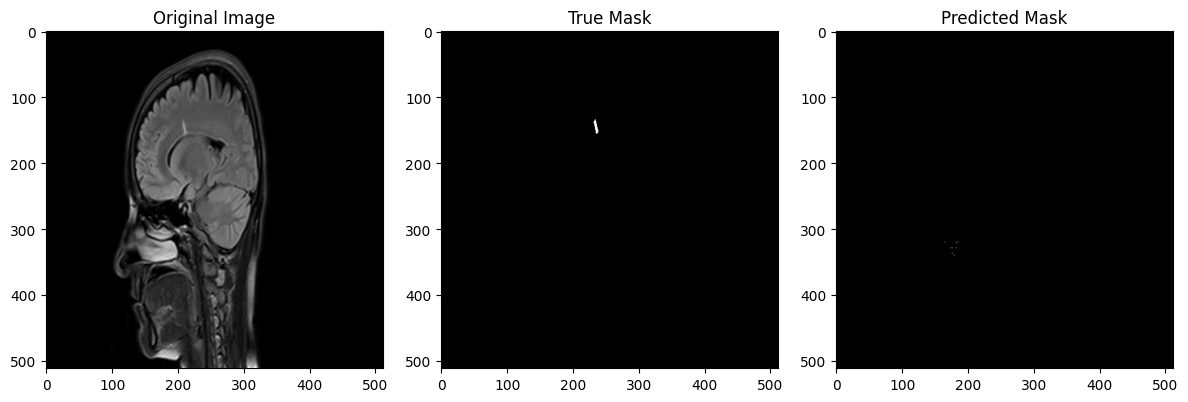

tensor(1)


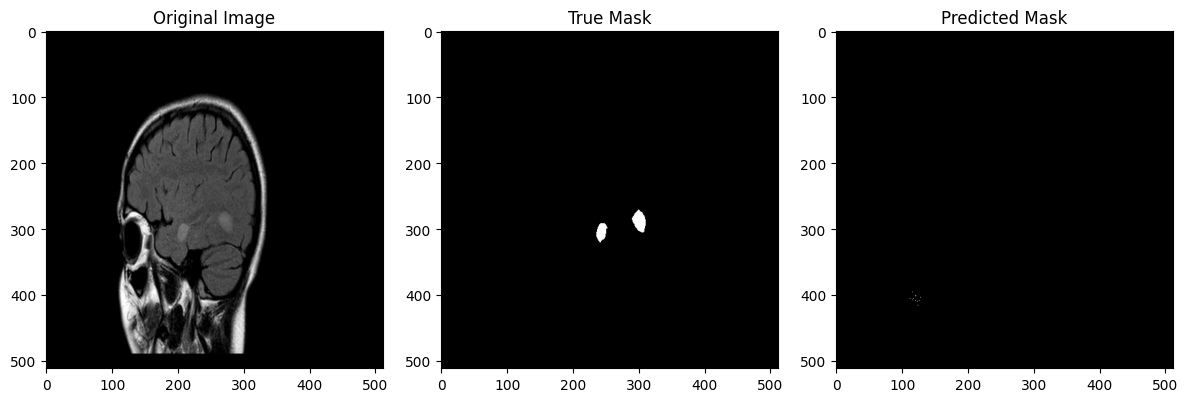

tensor(1)


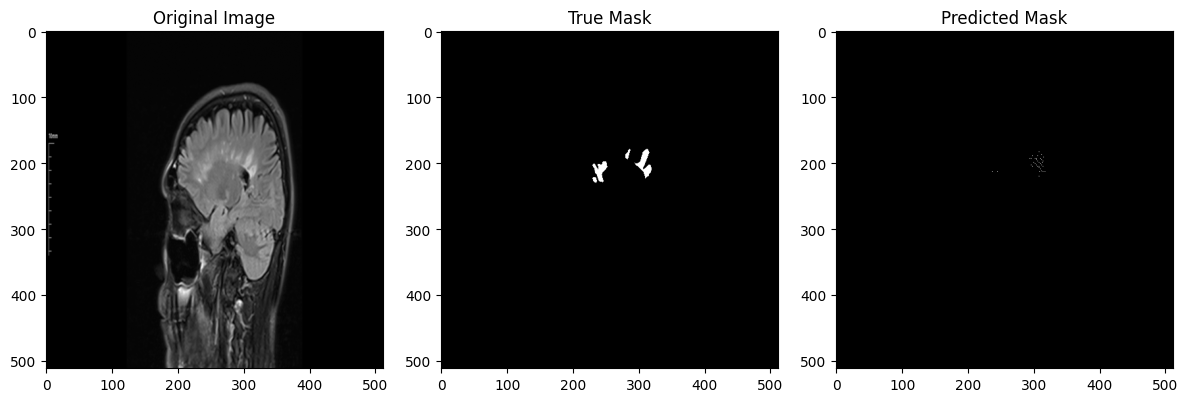

tensor(1)


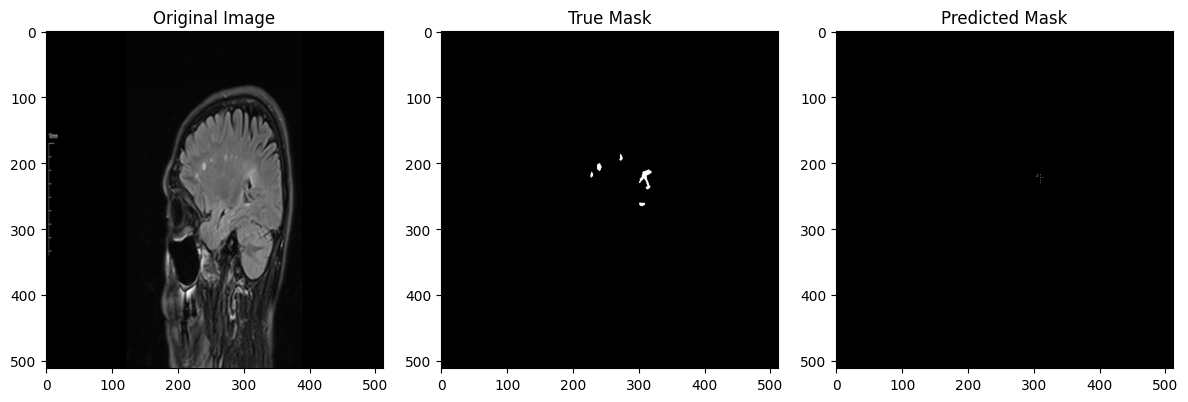

tensor(1)


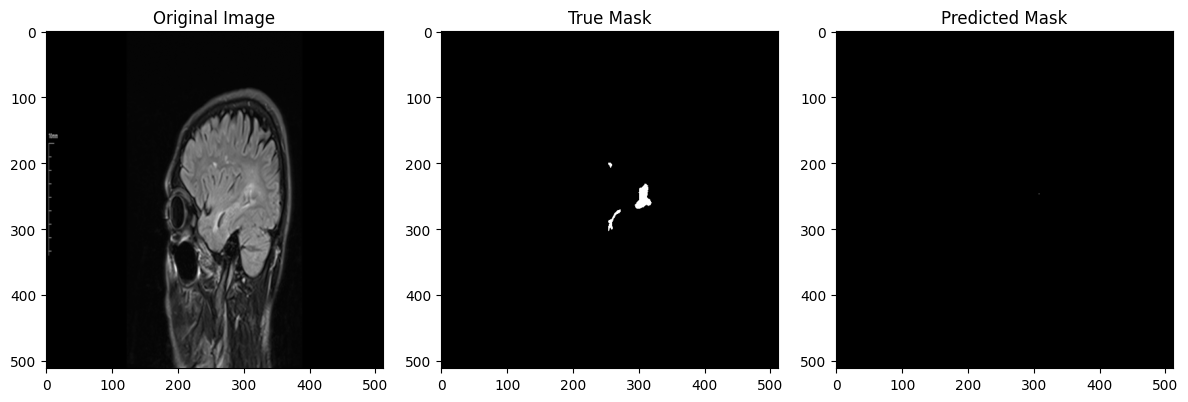

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

# Test dizinindeki görüntüleri ve maskeleri manuel olarak yükleme fonksiyonu
def load_test_data(image_dir, mask_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

    images = []
    masks = []

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Görüntüleri ve maskeleri gri tonlamaya çevirerek yükleme
        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path).convert('L')
        mask=np.array(mask)
        mask=mask>150
        images.append(np.array(image))
        masks.append(mask)

    return images, masks

# Test görüntüleri ve maskelerini yükleyelim
test_image_dir ='/content/name'
test_mask_dir = '/content/name'
test_images, test_masks = load_test_data(test_image_dir, test_mask_dir)
print(test_masks[0].max())

# Dönüştürme işlemi: Tensöre çevirme
transform = transforms.ToTensor()

# Test görüntülerini tensöre dönüştürme
test_images_tensor = [transform(img) for img in test_images]

# DataLoader ile test verisini yükleme
test_tensor_dataset = TensorDataset(torch.stack(test_images_tensor))
test_loader = DataLoader(test_tensor_dataset, batch_size=1, shuffle=False)

# Tahmin edilen maskeleri ve orijinal görüntüleri görselleştir
def visualize_predictions(image, predicted_mask, label_mask, output_path):
    plt.figure(figsize=(12, 4))

    # Orijinal görüntü
    plt.subplot(1, 3, 1)
    plt.imshow(image.squeeze(0), cmap='gray')
    plt.title("Original Image")

    # Gerçek maske (label)
    plt.subplot(1, 3, 2)
    plt.imshow(label_mask, cmap='gray')
    plt.title("True Mask")

    # Tahmin edilen maske
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")

    plt.tight_layout()
    plt.show()  # Görselleştirmeyi doğrudan ekranda gösteriyoruz

# Modeli değerlendirme moduna geçiriyoruz
model.eval()

# Test verisindeki görüntüler için tahmin ve görselleştirme işlemi
with torch.no_grad():
    for i, (test_image_batch,) in enumerate(test_loader):
        # Test görüntüsünü cihaza taşıyıp modelden geçirin
        test_image_batch = test_image_batch.to(device)
        outputs = model(test_image_batch)
        predicted_mask = torch.argmax(outputs, dim=1).squeeze(0).cpu()  # Tahmin edilen maske
        print(predicted_mask.max())


        # Görselleştirme: Orijinal test görüntüsü, gerçek maske ve tahmin edilen maske
        original_image = test_image_batch.squeeze(0).cpu()  # Orijinal test görüntüsünü elde ediyoruz
        label_mask = torch.tensor(test_masks[i])  # Gerçek maske
        visualize_predictions(original_image, predicted_mask, label_mask, f'test_image_{i}_visual.png')

        # Sadece ilk birkaç örneği görselleştirmek için sınır koyalım
        if i == 4:
            break

In [ ]:
print(label_mask)

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])


In [ ]:
print(label_mask.max())

tensor(True)


### **Modeli model.pth olarak kaydetme**

In [ ]:
# Modeli kaydetme
model_save_path = '/content/name/model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model başarıyla kaydedildi: {model_save_path}")

### **En iyi ve en kötü test sonuçlarının gösterimi**

En iyi tahmin sonucu:
En iyi tahmin IoU değeri: 0.021645021645021644


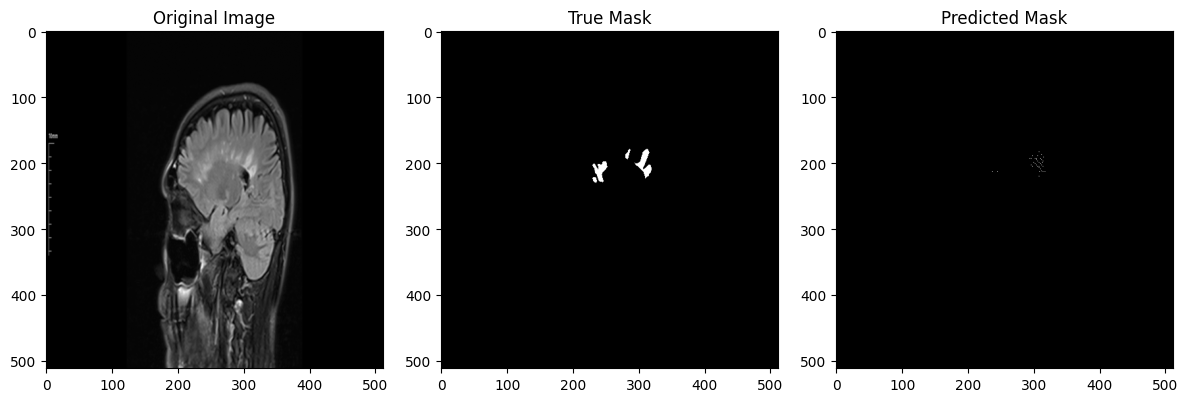

En kötü tahmin sonucu:
En kötü tahmin IoU değeri: 0.0


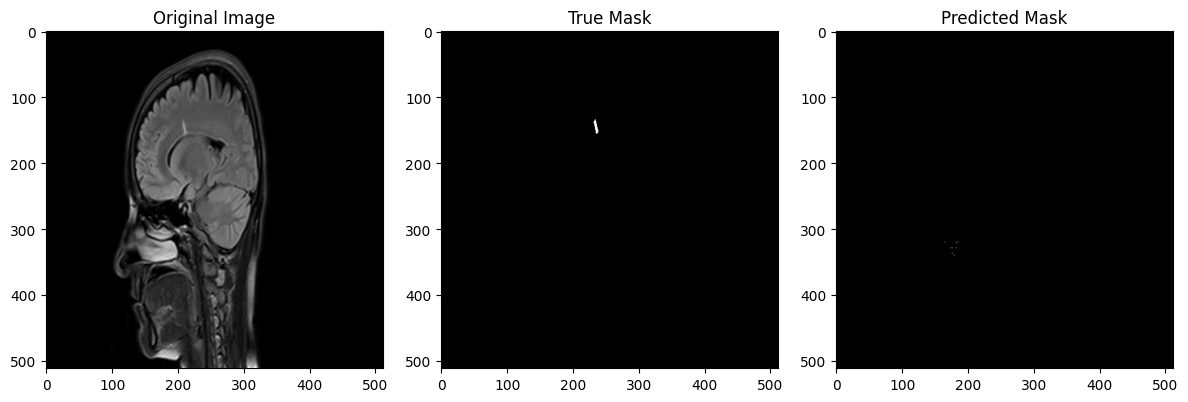

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import DataLoader
from monai.transforms import Compose, ScaleIntensity, EnsureType, Resize

# IoU (Intersection over Union) hesaplama fonksiyonu
def calculate_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask)
    union = np.logical_or(pred_mask, true_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# Test setindeki en iyi ve en kötü tahminleri bulma ve görselleştirme fonksiyonu
def find_best_and_worst_predictions(model, test_loader, true_masks, device):
    ious = []
    predictions = []
    original_images = []
    true_masks_array = []

    # Modeli değerlendirme moduna al
    model.eval()

    with torch.no_grad():
        for i, (test_image_batch,) in enumerate(test_loader):
            # Görüntüyü ve ilgili maskeyi cihaza yükle
            test_image_batch = test_image_batch.to(device)
            outputs = model(test_image_batch)
            predicted_mask = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()  # Tahmin edilen maske

            # IoU'yu hesapla
            true_mask = true_masks[i]
            iou = calculate_iou(predicted_mask, true_mask)
            ious.append(iou)

            # Orijinal görüntüleri ve tahminleri sakla
            original_images.append(test_image_batch.squeeze(0).cpu().numpy())
            predictions.append(predicted_mask)
            true_masks_array.append(true_mask)

    # En iyi ve en kötü tahminlerin sıralanması
    ious = np.array(ious)
    best_idx = np.argmax(ious)  # En yüksek IoU değerine sahip tahmin
    worst_idx = np.argmin(ious)  # En düşük IoU değerine sahip tahmin

    # En iyi tahmini görselleştir
    print("En iyi tahmin sonucu:")
    print(f"En iyi tahmin IoU değeri: {ious[best_idx]}")
    visualize_predictions(original_images[best_idx], predictions[best_idx], true_masks_array[best_idx], f'best_prediction.png')

    # En kötü tahmini görselleştir
    print("En kötü tahmin sonucu:")
    print(f"En kötü tahmin IoU değeri: {ious[worst_idx]}")
    visualize_predictions(original_images[worst_idx], predictions[worst_idx], true_masks_array[worst_idx], f'worst_prediction.png')

# Test setindeki en iyi ve en kötü tahminleri bul ve görselleştir
find_best_and_worst_predictions(model, test_loader, test_masks, device)

In [ ]:
def calculate_accuracy_percentage(model, test_loader, true_masks, device):
    model.eval()  # Modeli değerlendirme moduna geçir
    correct_pixels = 0
    total_pixels = 0

    with torch.no_grad():
        for i, (test_image_batch,) in enumerate(test_loader):
            # Test görüntülerini modele verip tahmin alın
            test_image_batch = test_image_batch.to(device)
            outputs = model(test_image_batch)
            predicted_mask = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()  # Tahmin edilen maske

            # Gerçek maske
            true_mask = true_masks[i]

            # Doğru tahmin edilen pikselleri hesapla
            correct_pixels += np.sum(predicted_mask == true_mask)

            # Toplam piksel sayısını güncelle
            total_pixels += true_mask.size

    # Doğruluk oranını yüzdelik olarak hesapla
    accuracy_percentage = (correct_pixels / total_pixels) * 100
    return accuracy_percentage

# Test setindeki doğruluk oranını hesapla
accuracy = calculate_accuracy_percentage(model, test_loader, test_masks, device)
print(f"Modelin Test Setindeki Doğruluk Oranı: {accuracy:.2f}%")


Modelin Test Setindeki Doğruluk Oranı: 99.77%
